## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys

In [2]:
sys.path.insert(0, os.getcwd()[:os.getcwd().rfind('\\')])
os.chdir(sys.path[0])

In [3]:
from scripts import Patient, Measurement, Simulator, Filter
from scripts import base_rule, sd_rule, arv_rule

## Data

In [4]:
df = pd.read_csv('data/diary_param.csv', sep='\t')
df.head()

,patient_id,doctor_id,MeasurementDateStart,MeasurementDateEnd,SystolicPressureMax,SystolicPressureMean,SystolicPressureMin,DiastolicPressureMax,DiastolicPressureMean,DiastolicPressureMin,PulseMax,PulseMean,PulseMin
0,194809,U6VN842K1A,2020-12-07T11:33:00+00:00,2020-12-07T11:33:00+00:00,138.0,138.0,138.0,76.0,76.0,76.0,52.0,52.0,52.0
1,194809,U6VN842K1A,2020-12-08T06:21:00+00:00,2020-12-08T06:21:00+00:00,122.0,122.0,122.0,65.0,65.0,65.0,51.0,51.0,51.0
2,194809,U6VN842K1A,2020-12-09T15:40:00+00:00,2020-12-09T15:40:00+00:00,110.0,110.0,110.0,55.0,55.0,55.0,56.0,56.0,56.0
3,194809,U6VN842K1A,2020-12-10T06:24:00+00:00,2020-12-10T06:24:00+00:00,110.0,110.0,110.0,60.0,60.0,60.0,52.0,52.0,52.0
4,194809,U6VN842K1A,2020-12-11T06:22:00+00:00,2020-12-11T06:22:00+00:00,102.0,102.0,102.0,55.0,55.0,55.0,51.0,51.0,51.0


In [5]:
patients = df.patient_id.unique()
print(f'There are {len(patients)} patients.')

There are 137 patients.


## Experiments

### 1 patient 1 simulation run

In [6]:
pat = patients[0]
df_1 = df[df.patient_id == pat]
df_1.to_csv(f'data/patient_{pat}', sep='\t', index=False)

In [7]:
p = Patient(f'data/patient_{pat}')

In [8]:
n_days = 30
sim = Simulator(p)
sim.run_simulation(n_days)

In [9]:
os.remove(f'data/patient_{pat}')  # don't need it anymore

In [10]:
for meas in sim.measurements:
    print(meas.sbp, meas.dbp)  # -1 is a missing measurement

109 82
118 62
115 59
130 83
157 112
88 60
100 75
106 81
93 64
-1 -1
105 57
132 82
92 67
121 81
97 76
115 66
108 88
102 75
-1 -1
88 61
99 72
97 69
88 62
139 87
88 65
130 76
91 68
135 90
115 65
92 66


In [11]:
# it's cool that when sbp (dbp) is -1, the map will be -1 :)
map_values = np.array([(meas.sbp + 2 * meas.dbp) / 3 for meas in sim.measurements])  # MAP is the mean arterial pressure

In [12]:
f = Filter([
            base_rule,
            sd_rule,
            arv_rule,
           ])

In [13]:
f.fit(sim.measurements)
results = f.apply(sim.measurements)[:]

In [14]:
def filter_missing(meas_array, apply_array):
    return np.where(meas_array == -1, None, apply_array)  # -1 is a missing measurement

In [15]:
filtered_vals = filter_missing(map_values, map_values)

In [16]:
def plot_meas_series(vals, checks, title=None):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(vals, 'o--', markersize='4')
    ax.plot(np.where(checks == True, None, vals), 'x', markersize='6', label='alerts')
    ax.set_xlabel('measurement number')
    ax.set_ylabel('MAP')
    ax.set_title(title)
    ax.legend();
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

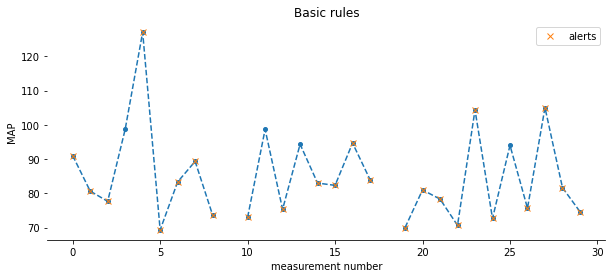

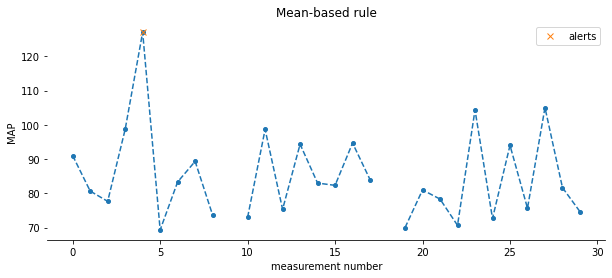

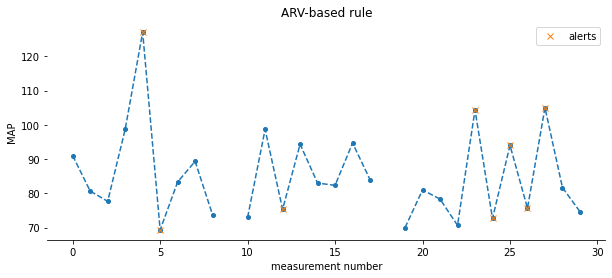

In [17]:
for checks, rule in zip(results, ['Basic rules', 'Mean-based rule', 'ARV-based rule']):
    plot_meas_series(filtered_vals, filter_missing(map_values, checks), rule)

### 1 patient many simulation runs

In [18]:
pat = 194937  # patients[0]
df_1 = df[df.patient_id == pat]
df_1.to_csv(f'data/patient_{pat}', sep='\t', index=False)

In [19]:
p = Patient(f'data/patient_{pat}')
p.state_prob.missing = .8

In [20]:
pat_meas = [Measurement(s, d) for s, d in zip(p.get_sbp_sequence(), p.get_dbp_sequence())] # fit на изначальном наборе измерений

In [21]:
%%time
n_days = 30
sim = Simulator(p)

sim_runs = []
for _ in range(100):
    sim.run_simulation(n_days)
    sim_runs.append(sim.measurements)
    sim.reset_simulation()

Wall time: 12.9 s


In [22]:
os.remove(f'data/patient_{pat}')  # don't need it anymore

In [23]:
checks = []
f = Filter([
            base_rule,
            sd_rule,
            arv_rule,
           ])
f.fit(pat_meas)
for sim_meas in sim_runs:
    checks.append(dict(zip(['base', 'sd', 'arv'], f.apply(sim_meas))))

In [24]:
base_load, sd_load, arv_load = [], [], []

for i, check in enumerate(checks):
    map_values = np.array([(meas.sbp + 2 * meas.dbp) / 3 for meas in sim_runs[i]])
    meas_cnt = (map_values != -1).sum() + 10e-10  # without missing
    base_load.append((filter_missing(map_values, check['base']) == False).sum() / meas_cnt)
    sd_load.append((filter_missing(map_values, check['sd']) == False).sum() / meas_cnt)
    arv_load.append((filter_missing(map_values, check['arv']) == False).sum() / meas_cnt)

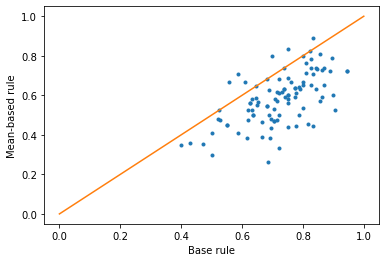

In [25]:
plt.plot(base_load, sd_load, '.')
plt.plot([0,1], [0,1], '-')
plt.xlabel('Base rule')
plt.ylabel('Mean-based rule');

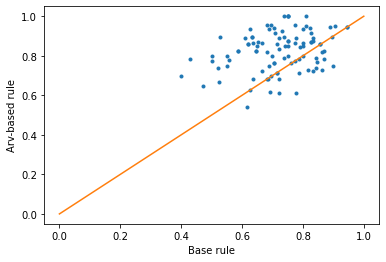

In [26]:
plt.plot(base_load, arv_load, '.')
plt.plot([0,1], [0,1], '-')
plt.xlabel('Base rule')
plt.ylabel('Arv-based rule');

### Many patients many simulation runs

In [27]:
from collections import defaultdict
from tqdm.notebook import tqdm

n_days = 30
results = defaultdict(dict)

for pat in tqdm(patients):
    df_1 = df[df.patient_id == pat]
    df_1.to_csv(f'data/patient_{pat}', sep='\t', index=False)
    p = Patient(f'data/patient_{pat}')
    pat_meas = [Measurement(s, d) for s, d in zip(p.get_sbp_sequence(), p.get_dbp_sequence())]
    
    sim = Simulator(p)
    sim_runs = []
    for _ in range(100):
        sim.run_simulation(n_days)
        sim_runs.append(sim.measurements)
        sim.reset_simulation()
    os.remove(f'data/patient_{pat}')
    
    checks = []
    f = Filter([
                base_rule,
                sd_rule,
                arv_rule,
               ])
    try:
        f.fit(pat_meas)
        for sim_meas in sim_runs:
            checks.append(dict(zip(['base', 'sd', 'arv'], f.apply(sim_meas))))
    except ValueError:
        continue
        
    base_load, sd_load, arv_load = [], [], []
    for i, check in enumerate(checks):
        map_values = np.array([(meas.sbp + 2 * meas.dbp) / 3 for meas in sim_runs[i]])
        meas_cnt = (map_values != -1).sum() + 10e-10  # without missing
        base_load.append((filter_missing(map_values, check['base']) == False).sum() / meas_cnt)
        sd_load.append((filter_missing(map_values, check['sd']) == False).sum() / meas_cnt)
        arv_load.append((filter_missing(map_values, check['arv']) == False).sum() / meas_cnt)
    
    results[pat] = {'base': base_load, 'sd': sd_load, 'arv': arv_load}

  0%|          | 0/137 [00:00<?, ?it/s]

Wall time: 24min 6s


In [28]:
base_load_means = [np.mean(results[p]['base']) for p in results]
sd_load_means = [np.mean(results[p]['sd']) for p in results]
arv_load_means = [np.mean(results[p]['arv']) for p in results]

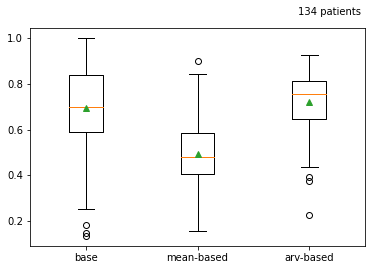

In [38]:
plt.boxplot([base_load_means, sd_load_means, arv_load_means],
            labels=['base', 'mean-based', 'arv-based'],
            showmeans=True)
plt.text(2.9,1.1,f'{len(base_load_means)} patients');

In [39]:
print(f"Base load mean: {np.mean(base_load_means)}\t ARV load mean: {np.mean(arv_load_means)}")

Base load mean: 0.691983140843371	 ARV load mean: 0.722486932076201
